NameError: name 'set_button_status' is not defined

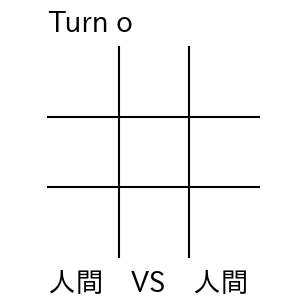

In [1]:
from util import gui_play

gui_play()

In [2]:
from marubatsu import Marubatsu_GUI

def update_widgets_status(self):   
    # 0 手目と最後の着手を行った局面で、特定のリプレイに関するボタンを操作できないようにする
    self.set_button_status(self.first_button, self.mb.move_count <= 0)
    self.set_button_status(self.prev_button, self.mb.move_count <= 0)
    self.set_button_status(self.next_button, self.mb.move_count >= len(self.mb.board_records) - 1)
    self.set_button_status(self.last_button, self.mb.move_count >= len(self.mb.board_records) - 1)          

Marubatsu_GUI.update_widgets_status = update_widgets_status

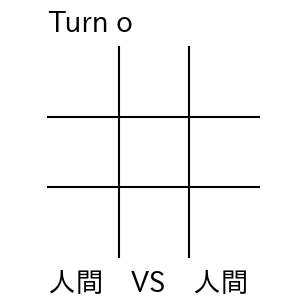

In [3]:
gui_play()

In [4]:
from marubatsu import Marubatsu
import matplotlib.patches as patches

@staticmethod
def draw_mark(ax, x, y, mark, color="black"):
    if mark == Marubatsu.CIRCLE:
        circle = patches.Circle([x + 0.5, y + 0.5], 0.35, ec=color, fill=False, lw=2)
        ax.add_artist(circle)
    elif mark == Marubatsu.CROSS:
        ax.plot([x + 0.15, x + 0.85], [y + 0.15, y + 0.85], c=color, lw="2")
        ax.plot([x + 0.15, x + 0.85], [y + 0.85, y + 0.15], c=color, lw="2")

Marubatsu_GUI.draw_mark = draw_mark

In [5]:
def draw_board(self):
    ax = self.ax
    ai = self.mb.ai
    
    # Axes の内容をクリアして、これまでの描画内容を削除する
    ax.clear()
    
    # y 軸を反転させる
    ax.invert_yaxis()
    
    # 枠と目盛りを表示しないようにする
    ax.axis("off")   
    
    # ゲームの決着がついていた場合は背景色を
    facecolor = "white" if self.mb.status == Marubatsu.PLAYING else "lightyellow"
    ax.figure.set_facecolor(facecolor)
        
    # 上部のメッセージを描画する
    # 対戦カードの文字列を計算する
    names = []
    for i in range(2):
        names.append("人間" if ai[i] is None else ai[i].__name__)
    ax.text(0, 3.5, f"{names[0]}　VS　{names[1]}", fontsize=20)   
    
    # ゲームの決着がついていない場合は、手番を表示する
    if self.mb.status == Marubatsu.PLAYING:
        text = "Turn " + self.mb.turn
    # 引き分けの場合
    elif self.mb.status == Marubatsu.DRAW:
        text = "Draw game"
    # 決着がついていれば勝者を表示する
    else:
        text = "Winner " + self.mb.status
    ax.text(0, -0.2, text, fontsize=20)
    
    # ゲーム盤の枠を描画する
    for i in range(1, self.mb.BOARD_SIZE):
        ax.plot([0, self.mb.BOARD_SIZE], [i, i], c="k") # 横方向の枠線
        ax.plot([i, i], [0, self.mb.BOARD_SIZE], c="k") # 縦方向の枠線   

    # ゲーム盤のマークを描画する
    for y in range(self.mb.BOARD_SIZE):
        for x in range(self.mb.BOARD_SIZE):
            color = "red" if (x, y) == self.mb.last_move else "black"
            self.draw_mark(ax, x, y, self.mb.board[x][y], color)            

    self.update_widgets_status() 
    
Marubatsu_GUI.draw_board = draw_board  

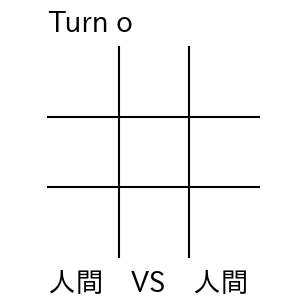

In [6]:
gui_play()

In [7]:
import math
from copy import deepcopy

def create_event_handler(self):
    # 変更ボタンのイベントハンドラを定義する
    def on_change_button_clicked(b):
        for i in range(2):
            ai[i] = None if dropdown_list[i].value == "人間" else dropdown_list[i].value
        self.play_loop(ai=ai, ax=ax, params=params, verbose=verbose, gui=gui)

    # リセットボタンのイベントハンドラを定義する
    def on_reset_button_clicked(b):
        self.restart()
        on_change_button_clicked(b)
        
    # イベントハンドラをボタンに結びつける
    change_button.on_click(on_change_button_clicked)
    reset_button.on_click(on_reset_button_clicked)   
    
    def change_step(step):
        # step の範囲を正しい範囲に修正する
        step = max(0, min(len(self.board_records) - 1, step))
        # step 手目のゲーム盤のデータをコピーし、board に代入する
        self.board = deepcopy(self.board_records[step])
        # 手数を表す step を move_count に代入する
        self.move_count = step
        # 手番を計算する。step が偶数の場合は 〇 の 手番
        self.turn = Marubatsu.CIRCLE if step % 2 == 0 else Marubatsu.CROSS
        # status 属性を judget を使って計算する
        self.status = self.judge()
        # 直前の着手を計算する
        self.last_move = self.records[step]
        # 描画を更新する
        self.draw_board(ax, ai)        

    def on_first_button_clicked(b):
        change_step(0)

    def on_prev_button_clicked(b):
        change_step(self.move_count - 1)

    def on_next_button_clicked(b):
        change_step(self.move_count + 1)
        
    def on_last_button_clicked(b):
        change_step(len(self.board_records) - 1)

    self.first_button.on_click(on_first_button_clicked)
    self.prev_button.on_click(on_prev_button_clicked)
    self.next_button.on_click(on_next_button_clicked)
    self.last_button.on_click(on_last_button_clicked)
    
    # ゲーム盤の上でマウスを押した場合のイベントハンドラ
    def on_mouse_down(event):
        # Axes の上でマウスを押していた場合のみ処理を行う
        if event.inaxes and self.status == Marubatsu.PLAYING:
            x = math.floor(event.xdata)
            y = math.floor(event.ydata)
            self.move(x, y)                
            self.draw_board(ax, ai)
            # 次の手番の処理を行うメソッドを呼び出す
            self.play_loop(ai=ai, ax=ax, params=params, verbose=verbose, gui=gui)
            
    # fig の画像にマウスを押した際のイベントハンドラを結び付ける
    fig.canvas.mpl_connect("button_press_event", on_mouse_down)    
               
Marubatsu_GUI.create_event_handler = create_event_handler

In [8]:
def change_step(self, step):
    # step の範囲を正しい範囲に修正する
    step = max(0, min(len(self.board_records) - 1, step))
    # step 手目のゲーム盤のデータをコピーし、board に代入する
    self.board = deepcopy(self.board_records[step])
    # 手数を表す step を move_count に代入する
    self.move_count = step
    # 手番を計算する。step が偶数の場合は 〇 の 手番
    self.turn = Marubatsu.CIRCLE if step % 2 == 0 else Marubatsu.CROSS
    # status 属性を judget を使って計算する
    self.status = self.judge()
    # 直前の着手を計算する
    self.last_move = self.records[step]

Marubatsu.change_step = change_step

In [9]:
def create_event_handler(self):
    # 変更ボタンのイベントハンドラを定義する
    def on_change_button_clicked(b):
        for i in range(2):
            ai[i] = None if dropdown_list[i].value == "人間" else dropdown_list[i].value
        self.play_loop(ai=ai, ax=ax, params=params, verbose=verbose, gui=gui)

    # リセットボタンのイベントハンドラを定義する
    def on_reset_button_clicked(b):
        self.restart()
        on_change_button_clicked(b)
        
    # イベントハンドラをボタンに結びつける
    change_button.on_click(on_change_button_clicked)
    reset_button.on_click(on_reset_button_clicked)   
    
    def change_step(step):
        self.mb.change_step(step)
        # 描画を更新する
        self.draw_board(ax, ai)        

    def on_first_button_clicked(b):
        change_step(0)

    def on_prev_button_clicked(b):
        change_step(self.move_count - 1)

    def on_next_button_clicked(b):
        change_step(self.move_count + 1)
        
    def on_last_button_clicked(b):
        change_step(len(self.board_records) - 1)

    self.first_button.on_click(on_first_button_clicked)
    self.prev_button.on_click(on_prev_button_clicked)
    self.next_button.on_click(on_next_button_clicked)
    self.last_button.on_click(on_last_button_clicked)
    
    # ゲーム盤の上でマウスを押した場合のイベントハンドラ
    def on_mouse_down(event):
        # Axes の上でマウスを押していた場合のみ処理を行う
        if event.inaxes and self.status == Marubatsu.PLAYING:
            x = math.floor(event.xdata)
            y = math.floor(event.ydata)
            self.move(x, y)                
            self.draw_board(ax, ai)
            # 次の手番の処理を行うメソッドを呼び出す
            self.play_loop(ai=ai, ax=ax, params=params, verbose=verbose, gui=gui)
            
    # fig の画像にマウスを押した際のイベントハンドラを結び付ける
    fig.canvas.mpl_connect("button_press_event", on_mouse_down)    
               
Marubatsu_GUI.create_event_handler = create_event_handler

In [10]:
def create_event_handler(self):
    # 変更ボタンのイベントハンドラを定義する
    def on_change_button_clicked(b):
        for i in range(2):
            self.mb.ai[i] = None if self.dropdown_list[i].value == "人間" else self.dropdown_list[i].value
        self.mb.play_loop()

    # リセットボタンのイベントハンドラを定義する
    def on_reset_button_clicked(b):
        self.mb.restart()
        on_change_button_clicked(b)
        
    # イベントハンドラをボタンに結びつける
    self.change_button.on_click(on_change_button_clicked)
    self.reset_button.on_click(on_reset_button_clicked)   
    
    def change_step(step):
        self.mb.change_step(step)
        # 描画を更新する
        self.draw_board()        

    def on_first_button_clicked(b):
        change_step(0)

    def on_prev_button_clicked(b):
        change_step(self.mb.move_count - 1)

    def on_next_button_clicked(b):
        change_step(self.mb.move_count + 1)
        
    def on_last_button_clicked(b):
        change_step(len(self.mb.board_records) - 1)

    self.first_button.on_click(on_first_button_clicked)
    self.prev_button.on_click(on_prev_button_clicked)
    self.next_button.on_click(on_next_button_clicked)
    self.last_button.on_click(on_last_button_clicked)
    
    # ゲーム盤の上でマウスを押した場合のイベントハンドラ
    def on_mouse_down(event):
        # Axes の上でマウスを押していた場合のみ処理を行う
        if event.inaxes and self.mb.status == Marubatsu.PLAYING:
            x = math.floor(event.xdata)
            y = math.floor(event.ydata)
            self.mb.move(x, y)                
            self.draw_board()
            # 次の手番の処理を行うメソッドを呼び出す
            self.mb.play_loop()
            
    # fig の画像にマウスを押した際のイベントハンドラを結び付ける
    self.fig.canvas.mpl_connect("button_press_event", on_mouse_down)    
               
Marubatsu_GUI.create_event_handler = create_event_handler

In [11]:
def __init__(self, mb, ai_dict=None, size=3):
    # ai_dict が None の場合は、空の list で置き換える
    if ai_dict is None:
        ai_dict = {}

    self.mb = mb
    self.ai_dict = ai_dict
    self.size = size
    
    # %matplotlib widget のマジックコマンドを実行する
    get_ipython().run_line_magic('matplotlib', 'widget')
        
    self.create_widgets()
    self.create_event_handler()
    self.display_widgets() 
        
Marubatsu_GUI.__init__ = __init__

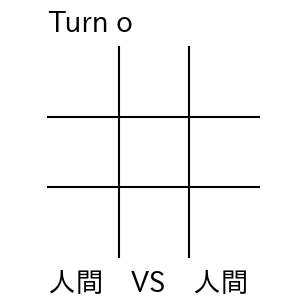

In [12]:
gui_play()

In [13]:
def play(self, ai, ai_dict=None, params=None, verbose=True, seed=None, gui=False, size=3):   
    # params が None の場合のデフォルト値を設定する
    if params is None:
        params = [{}, {}]
        
    # 一部の仮引数をインスタンスの属性に代入する
    self.ai = ai
    self.params = params
    self.verbose = verbose
    self.gui = gui
    
    # seed が None でない場合は、seed を乱数の種として設定する
    if seed is not None:
        random.seed(seed)


    # gui が True の場合に、GUI の処理を行う Marubatsu_GUI のインスタンスを作成する
    if gui:
        mb_gui = Marubatsu_GUI(self, ai_dict=ai_dict, size=size)    
        
    self.restart()
    return self.play_loop(mb_gui)

Marubatsu.play = play

In [14]:
def play_loop(self, mb_gui):   
    ai = self.ai
    params = self.params
    verbose = self.verbose
    gui = self.gui
    
    # ゲームの決着がついていない間繰り返す
    while self.status == Marubatsu.PLAYING:
        # 現在の手番を表す ai のインデックスを計算する
        index = 0 if self.turn == Marubatsu.CIRCLE else 1
        # ゲーム盤の表示
        if verbose:
            if gui:
                # AI どうしの対戦の場合は画面を描画しない
                if ai[0] is None or ai[1] is None:
                    mb_gui.draw_board()
                # 手番を人間が担当する場合は、play メソッドを終了する
                if ai[index] is None:
                    return
            else:
                print(self)
                
        # ai が着手を行うかどうかを判定する
        if ai[index] is not None:
            x, y = ai[index](self, **params[index])
        else:
            # キーボードからの座標の入力
            coord = input("x,y の形式で座標を入力して下さい。exit を入力すると終了します")
            # "exit" が入力されていればメッセージを表示して関数を終了する
            if coord == "exit":
                print("ゲームを終了します")
                return       
            # x 座標と y 座標を要素として持つ list を計算する
            xylist = coord.split(",")
            # xylist の要素の数が 2 ではない場合
            if len(xylist) != 2:
                # エラーメッセージを表示する
                print("x, y の形式ではありません")
                # 残りの while 文のブロックを実行せずに、次の繰り返し処理を行う
                continue
            x, y = xylist
        # (x, y) に着手を行う
        try:
            self.move(int(x), int(y))
        except:
            print("整数の座標を入力して下さい")

    # 決着がついたので、ゲーム盤を表示する
    if verbose:
        if gui:
            mb_gui.draw_board()
        else:
            print(self)
            
    return self.status

Marubatsu.play_loop = play_loop

In [15]:
def create_event_handler(self):
    # 変更ボタンのイベントハンドラを定義する
    def on_change_button_clicked(b):
        for i in range(2):
            self.mb.ai[i] = None if self.dropdown_list[i].value == "人間" else self.dropdown_list[i].value
        self.mb.play_loop(self)

    # リセットボタンのイベントハンドラを定義する
    def on_reset_button_clicked(b):
        self.mb.restart()
        on_change_button_clicked(b)
        
    # イベントハンドラをボタンに結びつける
    self.change_button.on_click(on_change_button_clicked)
    self.reset_button.on_click(on_reset_button_clicked)   
    
    def change_step(step):
        self.mb.change_step(step)
        # 描画を更新する
        self.draw_board()        

    def on_first_button_clicked(b):
        change_step(0)

    def on_prev_button_clicked(b):
        change_step(self.mb.move_count - 1)

    def on_next_button_clicked(b):
        change_step(self.mb.move_count + 1)
        
    def on_last_button_clicked(b):
        change_step(len(self.mb.board_records) - 1)

    self.first_button.on_click(on_first_button_clicked)
    self.prev_button.on_click(on_prev_button_clicked)
    self.next_button.on_click(on_next_button_clicked)
    self.last_button.on_click(on_last_button_clicked)
    
    # ゲーム盤の上でマウスを押した場合のイベントハンドラ
    def on_mouse_down(event):
        # Axes の上でマウスを押していた場合のみ処理を行う
        if event.inaxes and self.mb.status == Marubatsu.PLAYING:
            x = math.floor(event.xdata)
            y = math.floor(event.ydata)
            self.mb.move(x, y)                
            self.draw_board()
            # 次の手番の処理を行うメソッドを呼び出す
            self.mb.play_loop(self)
            
    # fig の画像にマウスを押した際のイベントハンドラを結び付ける
    self.fig.canvas.mpl_connect("button_press_event", on_mouse_down)    
               
Marubatsu_GUI.create_event_handler = create_event_handler

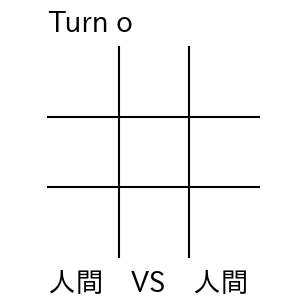

In [16]:
gui_play()

In [17]:
from ai import ai1s
mb = Marubatsu()

mb.play(ai=[ai1s, ai1s])

UnboundLocalError: cannot access local variable 'mb_gui' where it is not associated with a value

In [18]:
def play(self, ai, ai_dict=None, params=None, verbose=True, seed=None, gui=False, size=3):   
    # params が None の場合のデフォルト値を設定する
    if params is None:
        params = [{}, {}]
        
    # 一部の仮引数をインスタンスの属性に代入する
    self.ai = ai
    self.params = params
    self.verbose = verbose
    self.gui = gui
    
    # seed が None でない場合は、seed を乱数の種として設定する
    if seed is not None:
        random.seed(seed)

    # gui が True の場合に、GUI の処理を行う Marubatsu_GUI のインスタンスを作成する
    if gui:
        mb_gui = Marubatsu_GUI(self, ai_dict=ai_dict, size=size)  
    else:
        mb_gui = None
        
    self.restart()
    return self.play_loop(mb_gui)

Marubatsu.play = play

In [19]:
mb.play(ai=[ai1s, ai1s])

Turn o
...
...
...

Turn x
O..
...
...

Turn o
oX.
...
...

Turn x
oxO
...
...

Turn o
oxo
X..
...

Turn x
oxo
xO.
...

Turn o
oxo
xoX
...

winner o
oxo
xox
O..



'o'

In [20]:
from ai import ai_match

ai_match(ai=[ai1s, ai1s])

ai1s VS ai1s
count     win    lose    draw
o       10000       0       0
x           0   10000       0
total   10000   10000       0

ratio     win    lose    draw
o      100.0%    0.0%    0.0%
x        0.0%  100.0%    0.0%
total   50.0%   50.0%    0.0%



In [21]:
def restart(self):
    self.initialize_board()
    self.turn = Marubatsu.CIRCLE     
    self.move_count = 0
    self.status = Marubatsu.PLAYING
    self.last_move = -1, -1          
    self.last_turn = None
    self.records = [self.last_turn]
    
Marubatsu.restart = restart

In [22]:
def move(self, x, y):
    if self.place_mark(x, y, self.turn):
        self.last_turn = self.turn
        self.turn = Marubatsu.CROSS if self.turn == Marubatsu.CIRCLE else Marubatsu.CIRCLE  
        self.move_count += 1
        self.status = self.judge()
        self.last_move = x, y
        if len(self.records) <= self.move_count:            
            self.records.append(self.last_move)
        else:
            self.records[self.move_count] = self.last_move
            self.records = self.records[0:self.move_count + 1]

Marubatsu.move = move

In [23]:
def update_widgets_status(self):   
    # 0 手目と最後の着手を行った局面で、特定のリプレイに関するボタンを操作できないようにする
    self.set_button_status(self.first_button, self.mb.move_count <= 0)
    self.set_button_status(self.prev_button, self.mb.move_count <= 0)
    self.set_button_status(self.next_button, self.mb.move_count >= len(self.mb.records) - 1)
    self.set_button_status(self.last_button, self.mb.move_count >= len(self.mb.records) - 1)          

Marubatsu_GUI.update_widgets_status = update_widgets_status

In [24]:
def create_event_handler(self):
    # 変更ボタンのイベントハンドラを定義する
    def on_change_button_clicked(b):
        for i in range(2):
            self.mb.ai[i] = None if self.dropdown_list[i].value == "人間" else self.dropdown_list[i].value
        self.mb.play_loop(self)

    # リセットボタンのイベントハンドラを定義する
    def on_reset_button_clicked(b):
        self.mb.restart()
        on_change_button_clicked(b)
        
    # イベントハンドラをボタンに結びつける
    self.change_button.on_click(on_change_button_clicked)
    self.reset_button.on_click(on_reset_button_clicked)   
    
    def change_step(step):
        self.mb.change_step(step)
        # 描画を更新する
        self.draw_board()        

    def on_first_button_clicked(b):
        change_step(0)

    def on_prev_button_clicked(b):
        change_step(self.mb.move_count - 1)

    def on_next_button_clicked(b):
        change_step(self.mb.move_count + 1)
        
    def on_last_button_clicked(b):
        change_step(len(self.mb.records) - 1)

    self.first_button.on_click(on_first_button_clicked)
    self.prev_button.on_click(on_prev_button_clicked)
    self.next_button.on_click(on_next_button_clicked)
    self.last_button.on_click(on_last_button_clicked)
    
    # ゲーム盤の上でマウスを押した場合のイベントハンドラ
    def on_mouse_down(event):
        # Axes の上でマウスを押していた場合のみ処理を行う
        if event.inaxes and self.mb.status == Marubatsu.PLAYING:
            x = math.floor(event.xdata)
            y = math.floor(event.ydata)
            self.mb.move(x, y)                
            self.draw_board()
            # 次の手番の処理を行うメソッドを呼び出す
            self.mb.play_loop(self)
            
    # fig の画像にマウスを押した際のイベントハンドラを結び付ける
    self.fig.canvas.mpl_connect("button_press_event", on_mouse_down)    
               
Marubatsu_GUI.create_event_handler = create_event_handler

In [25]:
def play(self, ai, ai_dict=None, params=None, verbose=True, seed=None, gui=False, size=3):   
    # params が None の場合のデフォルト値を設定する
    if params is None:
        params = [{}, {}]
        
    # 一部の仮引数をインスタンスの属性に代入する
    self.ai = ai
    self.params = params
    self.verbose = verbose
    self.gui = gui
    
    # seed が None でない場合は、seed を乱数の種として設定する
    if seed is not None:
        random.seed(seed)

    # gui が True の場合に、GUI の処理を行う Marubatsu_GUI のインスタンスを作成する
    if gui:
        mb_gui = Marubatsu_GUI(self, ai_dict=ai_dict, size=size)  
    else:
        mb_gui = None
        
    self.restart()
    return self.play_loop(mb_gui)

Marubatsu.play = play

In [27]:
def change_step(self, step):
    # step の範囲を正しい範囲に修正する
    step = max(0, min(len(self.records) - 1, step))
    self.restart()
    for x, y in self.records[1:step+1]:
        self.move(x, y)

Marubatsu.change_step = change_step 

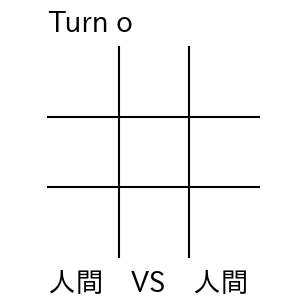

In [28]:
gui_play()

In [29]:
def change_step(self, step):
    # step の範囲を正しい範囲に修正する
    step = max(0, min(len(self.records) - 1, step))
    # self.records の値は restart メソッドを呼び出すと初期化されるので
    # ローカル変数 records に代入して取っておく
    records = self.records
    self.restart()
    for x, y in records[1:step+1]:
        self.move(x, y)

Marubatsu.change_step = change_step 

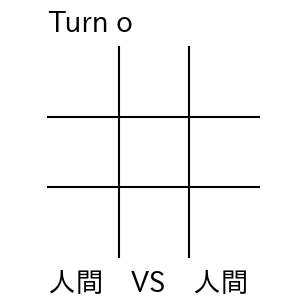

In [30]:
gui_play()

In [31]:
def change_step(self, step):
    # step の範囲を正しい範囲に修正する
    step = max(0, min(len(self.records) - 1, step))
    records = self.records
    self.restart()
    for x, y in records[1:step+1]:
        self.move(x, y)
    self.records = records

Marubatsu.change_step = change_step  

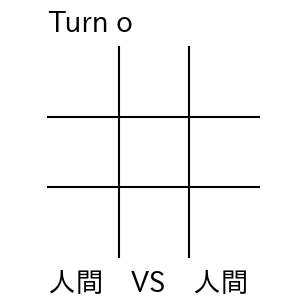

In [32]:
gui_play()

In [33]:
ai_match(ai=[ai1s, ai1s])

ai1s VS ai1s
count     win    lose    draw
o       10000       0       0
x           0   10000       0
total   10000   10000       0

ratio     win    lose    draw
o      100.0%    0.0%    0.0%
x        0.0%  100.0%    0.0%
total   50.0%   50.0%    0.0%

